In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error

rng = np.random.default_rng(2023)

In [ ]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

---

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv").dropna().drop(columns=["earnk"])

In [ ]:
df.head()

,height,weight,male,earn,ethnicity,education,mother_education,father_education,walk,exercise,smokenow,tense,angry,age
0,74,210.0,1,50000.0,White,16.0,16.0,16.0,3,3,2.0,0.0,0.0,45
1,66,125.0,0,60000.0,White,16.0,16.0,16.0,6,5,1.0,0.0,0.0,58
2,64,126.0,0,30000.0,White,16.0,16.0,16.0,8,1,2.0,1.0,1.0,29
4,63,110.0,0,50000.0,Other,16.0,16.0,16.0,5,6,2.0,0.0,0.0,91
5,68,165.0,0,62000.0,Black,18.0,18.0,18.0,1,1,2.0,2.0,2.0,54


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1815
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   height            1440 non-null   int64  
 1   weight            1440 non-null   float64
 2   male              1440 non-null   int64  
 3   earn              1440 non-null   float64
 4   ethnicity         1440 non-null   object 
 5   education         1440 non-null   float64
 6   mother_education  1440 non-null   float64
 7   father_education  1440 non-null   float64
 8   walk              1440 non-null   int64  
 9   exercise          1440 non-null   int64  
 10  smokenow          1440 non-null   float64
 11  tense             1440 non-null   float64
 12  angry             1440 non-null   float64
 13  age               1440 non-null   int64  
dtypes: float64(8), int64(5), object(1)
memory usage: 168.8+ KB


In [ ]:
df.describe()

,height,weight,male,earn,education,mother_education,father_education,walk,exercise,smokenow,tense,angry,age
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,66.667361,155.004167,0.377778,22356.176389,13.675694,13.675694,13.675694,5.347917,3.242361,1.750000,1.434028,1.434028,40.822222
std,3.779693,34.141104,0.485000,23863.753811,2.373345,2.373345,2.373345,2.567327,2.331823,0.433163,2.137350,2.137350,16.051829
min,57.000000,80.000000,0.000000,0.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,18.000000
25%,64.000000,130.000000,0.000000,7000.000000,12.000000,12.000000,12.000000,3.000000,1.000000,1.750000,0.000000,0.000000,29.000000
50%,66.000000,150.000000,0.000000,17800.000000,13.000000,13.000000,13.000000,6.000000,2.000000,2.000000,0.000000,0.000000,38.000000
75%,70.000000,175.000000,1.000000,30000.000000,16.000000,16.000000,16.000000,8.000000,6.000000,2.000000,2.000000,2.000000,51.000000
max,77.000000,312.000000,1.000000,400000.000000,18.000000,18.000000,18.000000,8.000000,7.000000,2.000000,7.000000,7.000000,91.000000


In [ ]:
df.smokenow.unique()

array([2., 1.])

In [ ]:
for var in ("male", "education", "mother_education", "father_education", "smokenow", "ethnicity"):
    df[var] = df[var].astype('category')

In [ ]:
for var in (var for var in df.columns if var not in ("male", "education", "mother_education", "father_education", "smokenow", "ethnicity")):
    print(var)
    df[var] = df[var].astype(float)

height
weight
earn
walk
exercise
tense
angry
age


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1815
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   height            1440 non-null   float64 
 1   weight            1440 non-null   float64 
 2   male              1440 non-null   category
 3   earn              1440 non-null   float64 
 4   ethnicity         1440 non-null   category
 5   education         1440 non-null   category
 6   mother_education  1440 non-null   category
 7   father_education  1440 non-null   category
 8   walk              1440 non-null   float64 
 9   exercise          1440 non-null   float64 
 10  smokenow          1440 non-null   category
 11  tense             1440 non-null   float64 
 12  angry             1440 non-null   float64 
 13  age               1440 non-null   float64 
dtypes: category(6), float64(8)
memory usage: 112.1 KB


---

# Dwa API

Implementacja biblioteki XGBoost w Pythonie dostarcza dwóch API:
1. scikit-learn API,
2. native API.

Scikit-learn API to wrapper native API, uwaga jednak na mniej lub bardziej oczywiste różnice w funkcjonalności pomiędzy API
(zob np. [Wątek na stackoverflow dot. różnic w API](https://stackoverflow.com/questions/37943403/difference-between-original-xgboost-learning-api-and-sklearn-xgbclassifier-sc)
lub
[dokumentację XGBoost dot. obsługi zmiennych kategorycznych](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html)).

# Zadanie 1

Utwórz prosty model XGBoost z użyciem scikit-learn API i dopasuj go do danych.
Pamiętaj, że zbiór danych zawiera zmienne kategoryczne - przygotuj odpowiednio dane i uwzględni to w modelu.

In [ ]:
df.head()

,height,weight,male,earn,ethnicity,education,mother_education,father_education,walk,exercise,smokenow,tense,angry,age
0,74.0,210.0,1,50000.0,White,16.0,16.0,16.0,3.0,3.0,2.0,0.0,0.0,45.0
1,66.0,125.0,0,60000.0,White,16.0,16.0,16.0,6.0,5.0,1.0,0.0,0.0,58.0
2,64.0,126.0,0,30000.0,White,16.0,16.0,16.0,8.0,1.0,2.0,1.0,1.0,29.0
4,63.0,110.0,0,50000.0,Other,16.0,16.0,16.0,5.0,6.0,2.0,0.0,0.0,91.0
5,68.0,165.0,0,62000.0,Black,18.0,18.0,18.0,1.0,1.0,2.0,2.0,2.0,54.0


In [ ]:
X = df.loc[:, [c for c in df.columns if c != "earn"]]
y = df.loc[:, "earn"]

In [ ]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = xgb.XGBRegressor(
    tree_method="hist", 
    enable_categorical=True,
    max_cat_to_onehot=3
)

clf.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=3, max_delta_step=None,
             max_depth=None, max_leaves=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

In [ ]:
mean_squared_error(clf.predict(X), y)

7221799.253294746

# Zadanie 2

Utwórz prosty model XGBoost z użyciem native API. Pamiętaj o zmiennych kategorycznych.

In [ ]:
type(X)

pandas.core.frame.DataFrame

In [ ]:
Xy = xgb.DMatrix(X, label=y, enable_categorical=True)
booster = xgb.train({"tree_method": "hist", "max_cat_to_onehot": 3}, Xy)

In [ ]:
type(booster)

xgboost.core.Booster

In [ ]:
type(clf)

xgboost.sklearn.XGBRegressor

In [ ]:
mean_squared_error(booster.predict(Xy), y)

189241625.27585813

---

# Zadanie 3

Utwórz zbiór treningowy i testowy (20\% obserwacji do zbioru testowego). Użyj ziarna losowania równego `2023`.

Dopasuj model używając native API z następującymi ustawieniami:
* funkcja straty MSE,
* metryka ewaluacyjna RMSE, którą śledzi na zbiorze testowym,
* metoda budowania drzew `hist`,
* 400 boosterów.

Zapisz metryki na zbiorach train/test dla każdego z $m$ kroków budowania finalnego modelu.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=2023
)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [ ]:
squared_error = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist'
}

results = {}

booster = xgb.train(
    squared_error,
    dtrain=dtrain,
    num_boost_round=400,
    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
    evals_result=results,
    verbose_eval=False
)

In [ ]:
booster.trees_to_dataframe().query("Tree == 300")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
29546,300,0,300-0,ethnicity,NaN,300-2,300-1,300-1,963.900146,1152.0,"[2, 3]"
29547,300,1,300-1,exercise,4.0,300-3,300-4,300-4,4245.258300,167.0,None
29548,300,2,300-2,education,NaN,300-6,300-5,300-5,1233.378780,985.0,"[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13]"
29549,300,3,300-3,age,44.0,300-7,300-8,300-8,5107.676760,86.0,None
29550,300,4,300-4,education,NaN,300-10,300-9,300-9,5917.456540,81.0,"[13, 15]"
...,...,...,...,...,...,...,...,...,...,...,...
29654,300,108,300-108,Leaf,NaN,NaN,NaN,NaN,-2.698779,20.0,NaN
29655,300,109,300-109,Leaf,NaN,NaN,NaN,NaN,-15.174867,5.0,NaN
29656,300,110,300-110,Leaf,NaN,NaN,NaN,NaN,-1.759229,2.0,NaN
29657,300,111,300-111,Leaf,NaN,NaN,NaN,NaN,3.739973,20.0,NaN


Wykreśl metrykę RMSE na zbiorze treningowym i testowym w zależności od $m$, tj. ilości drzew w finalnym modelu.

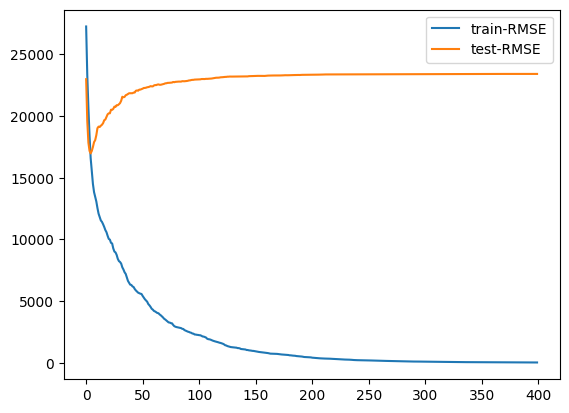

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(0, 400, 1), results['dtrain']['rmse'], label='train-RMSE')
ax.plot(np.arange(0, 400, 1), results['dtest']['rmse'], label='test-RMSE')

ax.legend(loc="best")

# Zadanie 4

Użyj scikit-learn API, aby dokonać kroswalidacji parametrów `eta` oraz `gamma`.

## Parametry

[opis parametrów booster'a z dok. XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster)

* $\eta$: "Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative."
* $\gamma$: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

Gamma is associated with "learning tree structure", while eta is associated with "model complexity" (it scales down gradients and thus speeds up/decreases pace of learning).

## `gamma`

[dok. XGBoost dot. parametru `gamma`](https://xgboost.readthedocs.io/en/stable/tutorials/model.html#learn-the-tree-structure):

\begin{equation}
Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma
\end{equation}

Zob. także [artykuł na medium.com](
https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6).

## `eta`

Na podstawie [wpisu na medium.com](https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283)

\begin{align}
\hat{f}^{(m)}(x) = \hat{f}^{(m-1)}(x)  + &\hat{f}_m(x)
\\
&\hat{f}_m(x) = \eta \sum_{j=1}^T \hat{w}_{jm} I (x \in \hat{R}_{jm})
\end{align}

In [ ]:
gbm = xgb.XGBRegressor(
    enable_categorical=True,
    tree_method='hist',
    objective='reg:squarederror',
    eval_metric='rmse'
)

gbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 0.9],
    'n_estimators': [400],
    'gamma': [0.3, 0.5, 0.9]
}

grid_mse = GridSearchCV(
    estimator=gbm,
    param_grid=gbm_param_grid,
    scoring='neg_mean_squared_error', 
    cv=5, 
    verbose=1
)

grid_mse.fit(X, y)

print("Best parameters found: ",grid_mse.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'gamma': 0.3, 'learning_rate': 0.01, 'n_estimators': 400}


Dopasowanie modelu z optymalnymi wartościami `eta` oraz `gamma`

In [ ]:
squared_error = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'gamma': grid_mse.best_params_["gamma"],
    'eta': grid_mse.best_params_.get("learning_rate")
}

results = {}

booster_opt = xgb.train(
    squared_error,
    dtrain=dtrain,
    num_boost_round=400,
    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
    evals_result=results,
    verbose_eval=False
)

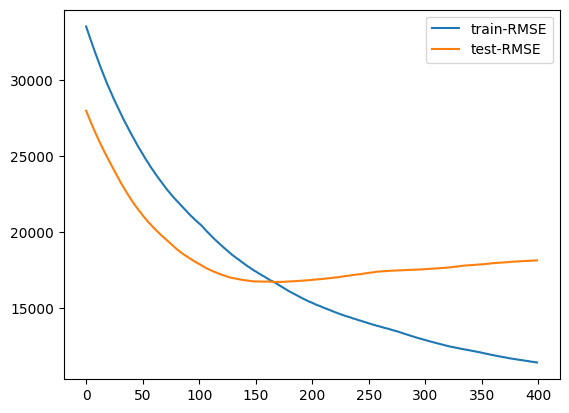

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(0, 400, 1), results['dtrain']['rmse'], label='train-RMSE')
ax.plot(np.arange(0, 400, 1), results['dtest']['rmse'], label='test-RMSE')

ax.legend(loc="best")

# Zadanie 5

Co możemy zrobić, żeby stworzyć lepszy model?

Jeden z pomysłów: zastanówmy się nad użytą funkcją straty. Czy na pewno to dobry wybór w naszym problemie (tj. dla naszego zbioru danych)?

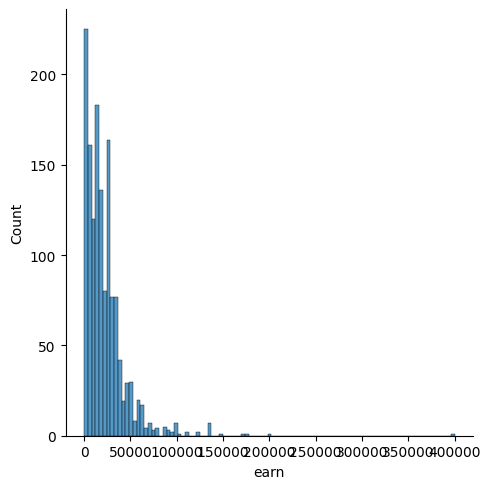

In [ ]:
sns.displot(df["earn"])

<Axes: >

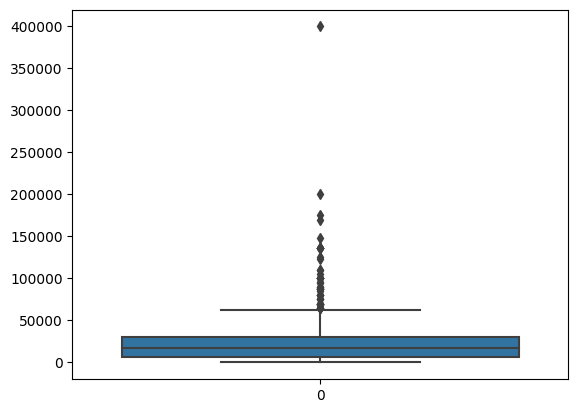

In [ ]:
sns.boxplot(df["earn"])

# Zadanie 5 a)

Mamy całkiem sporo outlierów. Zaproponuj funkcję straty (i odpowiednią metrykę), która lepiej poradzi sobie z tym problemem od MSE.